# Fluxing with PYPIT [v1.0]

In [1]:
%matplotlib inline

In [2]:
# import
from importlib import reload
import os
from matplotlib import pyplot as plt
import glob
import numpy as np

from astropy.table import Table

from pypit import fluxspec

## To play along, you need the Development suite *reduced* 

### And the $PYPIT_DEV environmental variable pointed at it

In [3]:
os.getenv('PYPIT_DEV')

'/home/xavier/local/Python/PYPIT-development-suite/'

## Instantiate from spec1d file

In [4]:
std_file = os.getenv('PYPIT_DEV')+'REDUX_OUT/Shane_Kast_blue/600_4310_d55/shane_kast_blue_setup_A/Science/spec1d_Feige66_KASTb_2015May20T041246.96.fits'
sci_file = os.getenv('PYPIT_DEV')+'REDUX_OUT/Shane_Kast_blue/600_4310_d55/shane_kast_blue_setup_A/Science/spec1d_J1217p3905_KASTb_2015May20T045733.56.fits'

In [5]:
# nit
reload(fluxspec)
FxSpec = fluxspec.FluxSpec(std_spec1d_file=std_file, spectrograph='shane_kast_blue', sci_spec1d_file=sci_file, setup='A_01_aa')

[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: arparse.py 87 load_file() - Loading base settings from settings.baseargflag
[INFO]    :: arparse.py 1393 run_ncpus() - Setting 7 CPUs
[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: arparse.py 87 load_file() - Loading base settings from settings.basespect
[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: arparse.py 87 load_file() - Loading base settings from settings.basespect
[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: fluxspec.py 100 __init__() - Loaded 1 spectra from the spec1d standard star file: /home/xavier/local/Python/PYPIT-development-suite/REDUX_OUT/Shane_Kast_blue/600_4310_d55/shane_kast_blue_setup_A/Science/spec1d_Feige66_KASTb_2015May20T041246.96.fits
[INFO]    :: fluxspec

## Find the standard (from the brightest spectrum)

In [6]:
std = FxSpec.find_standard()
std

[INFO]    :: arflux.py 435 find_standard() - Putative standard star has a median boxcar count of 16571.570777816214


<SpecObjExp: O479-S5009-D01-I0023 == Setup dum_config Object at 0.479 in Slit at 0.5009 with det=01, scidx=23 and objtype=unknown>

## Sensitivity Function

In [7]:
sensfunc = FxSpec.generate_sensfunc()
sensfunc

[INFO]    :: arflux.py 370 load_extinction_data() - Using mthamextinct.dat for extinction corrections.
[INFO]    :: arflux.py 300 find_standard_file() - Using standard star FEIGE66
[INFO]    :: arflux.py 406 load_standard_file() - Loading standard star file: /home/xavier/local/Python/PYPIT/pypit/data/standards/calspec/feige66_002.fits.gz
[INFO]    :: arflux.py 407 load_standard_file() - Fluxes are flambda, normalized to 1e-17
[INFO]    :: arflux.py 500 generate_sensfunc() - Masking edges
[WARNING] :: arflux.py 506 generate_sensfunc() - Should pull resolution from arc line analysis
[INFO]    :: arflux.py 510 generate_sensfunc() - Masking Balmer
[INFO]    :: arflux.py 518 generate_sensfunc() - Masking Telluric
[INFO]    :: arflux.py 525 generate_sensfunc() - Masking Below the atmospheric cutoff
[INFO]    :: arflux.py 203 bspline_magfit() - Difference between fits is 0.00017687
[WORK IN ]::
[PROGRESS]:: arflux.py 206 bspline_magfit() - Add QA for sensitivity function


{'c': [array([ 3436.90890455,  3436.90890455,  3436.90890455,  3436.90890455,
          3478.25918977,  3519.609475  ,  3560.95976022,  3602.31004545,
          3643.66033067,  3685.0106159 ,  3726.36090112,  3767.71118635,
          3809.06147157,  3850.4117568 ,  3891.76204202,  3933.11232725,
          3974.46261247,  4015.8128977 ,  4057.16318292,  4098.51346815,
          4139.86375337,  4181.2140386 ,  4222.56432382,  4263.91460905,
          4305.26489427,  4346.6151795 ,  4387.96546472,  4429.31574995,
          4470.66603518,  4512.0163204 ,  4553.36660563,  4594.71689085,
          4636.06717608,  4677.4174613 ,  4718.76774653,  4760.11803175,
          4801.46831698,  4842.8186022 ,  4884.16888743,  4925.51917265,
          4966.86945788,  5008.2197431 ,  5049.57002833,  5090.92031355,
          5132.27059878,  5173.620884  ,  5214.97116923,  5256.32145445,
          5297.67173968,  5339.0220249 ,  5380.37231013,  5421.72259535,
          5463.07288058,  5504.42316581,  5504

### Plot

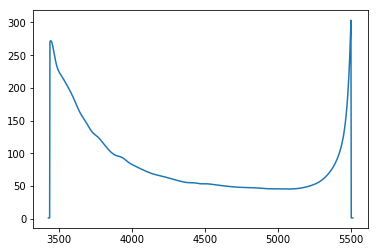

In [8]:
FxSpec.show_sensfunc()

In [9]:
FxSpec.steps

['find_standard', 'generate_sensfunc']

## Flux science

In [10]:
FxSpec.flux_science()

[INFO]    :: arflux.py 370 load_extinction_data() - Using mthamextinct.dat for extinction corrections.
[INFO]    :: arflux.py 46 new_apply_sensfunc() - Fluxing boxcar extraction for:
             <SpecObjExp: O500-S5009-D01-I0024 == Setup dum_config Object at 0.5 in Slit at 0.5009 with det=01, scidx=24 and objtype=unknown>
[INFO]    :: arflux.py 46 new_apply_sensfunc() - Fluxing optimal extraction for:
             <SpecObjExp: O500-S5009-D01-I0024 == Setup dum_config Object at 0.5 in Slit at 0.5009 with det=01, scidx=24 and objtype=unknown>


In [11]:
FxSpec.sci_specobjs[0].optimal

{'counts': array([ 14.47197962,  17.97570501,  26.44744019, ...,  46.31827594,
         34.98441373,  49.78903766]),
 'flam': array([ 0.02342644,  0.02907752,  0.04275117, ...,  0.04550007,
         0.0343651 ,  0.04890578]),
 'flam_var': array([ 0.00035862,  0.00042775,  0.00038943, ...,  0.00015267,
         0.00014345,  0.00015216]),
 'var': array([ 136.85927251,  163.47284663,  149.0407738 , ...,  158.21252732,
         148.67120378,  157.7107462 ]),
 'wave': <Quantity [ 3428.02418628, 3428.91668777, 3429.80934137,...,
             5513.32205621, 5514.42622645, 5515.53044565] Angstrom>}

### Plot

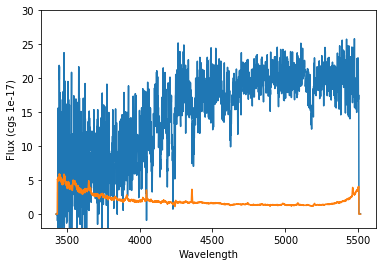

In [12]:
plt.clf()
ax = plt.gca()
ax.plot(FxSpec.sci_specobjs[0].optimal['wave'], FxSpec.sci_specobjs[0].optimal['flam'])
ax.plot(FxSpec.sci_specobjs[0].optimal['wave'], np.sqrt(FxSpec.sci_specobjs[0].optimal['flam_var']))
ax.set_ylim(-2, 30.)
# 
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux (cgs 1e-17)')
plt.show()

### Write

In [13]:
FxSpec.write_science('tmp.fits')

[INFO]    :: arsave.py 459 new_save_1d_spectra_fits() - Wrote 1D spectra to tmp.fits


In [14]:
FxSpec.steps

['find_standard', 'generate_sensfunc', 'flux_science', 'write_science']

## MasterFrames

In [15]:
FxSpec.setup = 'A_01_aa'

In [16]:
FxSpec.settings['masters']

{'directory': 'MF_shane_kast_blue',
 'force': False,
 'loaded': [],
 'reuse': False}

### Save

In [17]:
os.mkdir('MF_shane_kast_blue')
FxSpec.save_master()

[INFO]    :: fluxspec.py 195 save_master() - Wrote sensfunc to MasterFrame: MF_shane_kast_blue/MasterSensFunc_A_aa.yaml


### Load

In [18]:
sensfunc2, _, _ = FxSpec.load_master_frame(force=True)
sensfunc2.keys()

dict_keys(['c', 'func', 'max', 'min', 'std', 'steps', 'wave_max', 'wave_min'])

## Instantiate from a sensitivity function

In [19]:
reload(fluxspec)
FxSpec3 = fluxspec.FluxSpec(sci_spec1d_file=sci_file, sens_file='MF_shane_kast_blue/MasterSensFunc_A_aa.yaml')

[INFO]    :: fluxspec.py 103 __init__() - Loaded spectra from the spec1d science file: /home/xavier/local/Python/PYPIT-development-suite/REDUX_OUT/Shane_Kast_blue/600_4310_d55/shane_kast_blue_setup_A/Science/spec1d_J1217p3905_KASTb_2015May20T045733.56.fits
[WARNING] :: masterframe.py 55 __init__() - MasterFrame class not proper loaded (e.g. no masters in settings).  Avoid using Master methods


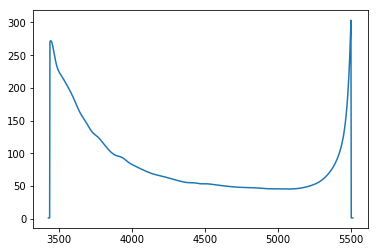

In [20]:
FxSpec3.show_sensfunc()

## Clean up


In [21]:
os.remove(FxSpec.ms_name)
os.rmdir('MF_shane_kast_blue')

----

## Development

In [22]:
reload(fluxspec)
FxSpec = fluxspec.FluxSpec(std_spec1d_file=std_file, spectrograph='shane_kast_blue', sci_spec1d_file=sci_file, setup='A_01_aa')

[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: arparse.py 87 load_file() - Loading base settings from settings.baseargflag
[INFO]    :: arparse.py 1393 run_ncpus() - Setting 7 CPUs
[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: arparse.py 87 load_file() - Loading base settings from settings.basespect
[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: arparse.py 87 load_file() - Loading base settings from settings.basespect
[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: fluxspec.py 100 __init__() - Loaded 1 spectra from the spec1d standard star file: /home/xavier/local/Python/PYPIT-development-suite/REDUX_OUT/Shane_Kast_blue/600_4310_d55/shane_kast_blue_setup_A/Science/spec1d_Feige66_KASTb_2015May20T041246.96.fits
[INFO]    :: fluxspec

In [23]:
FxSpec.std_specobjs[0].idx

'O479-S5009-D01-I0023'

In [24]:
FxSpec._set_std_obj('O479-S5009-D01-I0023')

<SpecObjExp: O479-S5009-D01-I0023 == Setup dum_config Object at 0.479 in Slit at 0.5009 with det=01, scidx=23 and objtype=unknown>

In [25]:
FxSpec._set_std_obj(1)

<SpecObjExp: O479-S5009-D01-I0023 == Setup dum_config Object at 0.479 in Slit at 0.5009 with det=01, scidx=23 and objtype=unknown>

In [26]:
FxSpec.std

<SpecObjExp: O479-S5009-D01-I0023 == Setup dum_config Object at 0.479 in Slit at 0.5009 with det=01, scidx=23 and objtype=unknown>

### Todo
    Script
    Deal with standard running across multiple detectors (DEIMOS)